In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time

import networkx as nx
import matplotlib.pyplot as plt

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [223]:
class SpringSim(object):
    def __init__(self, n_balls=5, box_size=5., loc_std=3, vel_norm=.5,
                 interaction_strength=.1, noise_var=0.):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._spring_types = np.array([0., 0.5, 1.])
        self._delta_T = 0.001
        self._max_F = 0.1 / self._delta_T


    def _clamp(self, loc, vel):
        '''
        :param loc: 2xN location at one time stamp
        :param vel: 2xN velocity at one time stamp
        :return: location and velocity after hiting walls and returning after
            elastically colliding with walls
        '''
        assert (np.all(loc < self.box_size * 3))
        assert (np.all(loc > -self.box_size * 3))

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert (np.all(loc <= self.box_size))

        # assert(np.all(vel[over]>0))
        vel[over] = -np.abs(vel[over])

        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        # assert (np.all(vel[under] < 0))
        assert (np.all(loc >= -self.box_size))
        vel[under] = np.abs(vel[under])

        return loc, vel


    def sample_trajectory(self, T=100000, sample_freq=100, spring_prob=[4./5, 0, 1./5]):
        n = self.n_balls
        assert (T % sample_freq == 0)
        T_save = int(T / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        # Sample edges
        # grid = nx.grid_2d_graph(n=10, m=10, periodic=False)
        grid = nx.barabasi_albert_graph(n=n, m=3)
        edges = nx.adj_matrix(grid).toarray()
#         edges = np.random.choice(self._spring_types,
#                                  size=(self.n_balls, self.n_balls),
#                                  p=spring_prob)
        edges = np.tril(edges) + np.tril(edges, -1).T
        np.fill_diagonal(edges, 0)
        # Initialize location and velocity
        loc = np.zeros((T_save, 2, n))
        vel = np.zeros((T_save, 2, n))
        # loc_next = np.random.randn(2, n) * self.loc_std
        loc_next = np.stack(nx.kamada_kawai_layout(grid).values()).T * self.loc_std
#         vel_next = np.random.randn(2, n)
#         v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
#         vel_next = vel_next * self.vel_norm / v_norm
        vel_next = np.zeros((2, n))
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):

            forces_size = - self.interaction_strength * edges
            np.fill_diagonal(forces_size,
                             0)  # self forces are zero (fixes division by zero)
            F = (forces_size.reshape(1, n, n) *
                 np.concatenate((
                     np.subtract.outer(loc_next[0, :],
                                       loc_next[0, :]).reshape(1, n, n),
                     np.subtract.outer(loc_next[1, :],
                                       loc_next[1, :]).reshape(1, n, n)))).sum(
                axis=-1)
            F[F > self._max_F] = self._max_F
            F[F < -self._max_F] = -self._max_F

            vel_next += self._delta_T * F
            # run leapfrog
            for i in range(1, T):
                loc_next += self._delta_T * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                forces_size = - self.interaction_strength * edges
                np.fill_diagonal(forces_size, 0)
                # assert (np.abs(forces_size[diag_mask]).min() > 1e-10)
                
                x_axis = np.subtract.outer(loc_next[0, :], loc_next[0, :])
                idx1 = x_axis>0
                idx2 = x_axis<0
                x_axis[idx1] -= 0.5
                x_axis[idx2] += 0.5
                x_axis = x_axis.reshape(1, n, n)
                
                y_axis = np.subtract.outer(loc_next[1, :], loc_next[1, :])
                idx1 = y_axis>0
                idx2 = y_axis<0
                y_axis[idx1] -= 0.5
                y_axis[idx2] += 0.5
                y_axis = y_axis.reshape(1, n, n)
                
                F = (forces_size.reshape(1, n, n) * np.concatenate((x_axis, y_axis))).sum(axis=-1)
                F[F > self._max_F] = self._max_F
                F[F < -self._max_F] = -self._max_F
                vel_next += self._delta_T * F 
            # Add noise to observations
            loc += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges

In [224]:
model = SpringSim(n_balls=10)

In [225]:
loc, vel, edges = model.sample_trajectory()

t:   0%|          | 2/600 [00:00<00:31, 18.89it/s, now=None]

MoviePy - Building file G.gif with imageio.


t: 100%|██████████| 600/600 [01:01<00:00,  9.40it/s, now=None]

KeyboardInterrupt: 

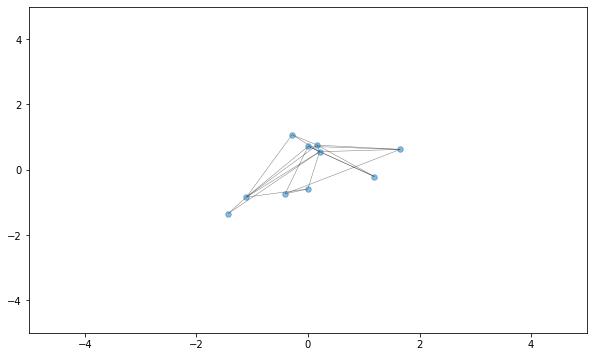

In [226]:
fig_mpl, ax = plt.subplots(1,figsize=(10,6), facecolor='white')

FPS = 120

def draw(G, one_loc):
    pos = {node:position for node, position in zip(G.nodes(), one_loc)}
    nx.draw(G, pos=pos, ax=ax, node_size=30, width=0.5, alpha=0.5)
    ax.set_axis_on()
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
def make_frame_mpl(t):
    ax.clear()
    t = int(t*FPS)
    one_loc = loc[t].T
    draw(G, one_loc)
    return mplfig_to_npimage(fig_mpl) # 图形的RGB图像

G = nx.Graph()
G = nx.from_numpy_array(edges)
animation =mpy.VideoClip(make_frame_mpl, duration=5)
animation.write_gif("G.gif", fps=FPS)